# Computing the SSI of isolated neurons

Here, we consider a system made of only one neuron, which takes stimuli directions as inputs and outputs a variable spikes count in response.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
from tqdm import tqdm_notebook as tqdm
import math
import time
from scipy.stats import poisson
from scipy.stats import nbinom
import scipy.special
from scipy.optimize import root
from scipy.interpolate import CubicSpline


In [5]:
### numeric simulation parameters ###

# granularity for simulation
n_step = 1
theta_step = 1

# range of value for theta and n
n_range = np.arange(0,300,n_step) # no need to go higher for n < 150
theta_range = np.arange(-180,180,theta_step)

# the stimuli direction theta follows a uniform distribution
p_theta = 1/len(theta_range)

In [6]:
### tuning curve of the neuron ###

# parameters of the tuning curve
# shape, width and height
shape, sigma,f0 = "bell+baseline",22.2,100

def f(theta):
    if shape == "bell":
        theta_0 = 0
        sigma = 30
        return f0*(np.exp(-(theta - theta_0)**2 / (2 * sigma**2)))
    if (shape == "cos") :
        return(max(0,f0*((np.cos(np.deg2rad(theta))-0.14))/0.86))
    if (shape == "bell+baseline"):
        sigma = 22.2
        return f0*(0.84*np.exp(-(theta)**2 / (2 * sigma**2)) +0.16)
    if (shape == "sigmoid"):
        lambd = 0.1
        return(1/(1+np.exp(-lambd*theta)))
    else :
        return(0)

In [7]:
### probability laws parameters ###

# time bin to count the spikes (second)
time_bin = 0.3

# deviation from poisson for Negative Binomial
R = 50

# gamma and Maxrange for subpoisson
gamma, maxRange = -0.05, n_range[-1]

In [8]:
### Spiking model functions for the Subpoisson case ###


def create_spiking_model(gamma, maxRange=10):
    '''
    Creates a SpikingModel instance
        inputs:
            gamma: float, 0 for Poisson process, negative for subPoisson
            maxRange: integer, maximum value of spike count
        output:
            Model: SpikingModel instance
    '''
    sigmas = np.arange(0, maxRange+10+1)  # can't start at 0... is it a major issue ? 
    logFactSig = scipy.special.gammaln(sigmas+1)
    logWeight = lambda th, gg: th * sigmas + gg * sigmas ** 2 - logFactSig
    #zed = lambda th, gg: np.sum(weight(th, gg))
    logZed = lambda th, gg: scipy.special.logsumexp(logWeight(th, gg))
    meanSt = lambda th, gg: np.exp(  scipy.special.logsumexp(logWeight(th, gg) + np.log(sigmas +10**-10))  - logZed(th, gg)  )
    meanNd = lambda th, gg: np.exp( scipy.special.logsumexp(logWeight(th, gg) + np.log(sigmas ** 2 +10**-10)) - logZed(th, gg) )

    lambdas = np.arange(10**-3, maxRange+10, 1/200)

    theta = np.array([root(lambda th: meanSt(th, gamma) - ll,
                                     np.log(ll/(1+ll)), method='hybr').x
                                for ll in lambdas])[:,0]
    
    thetaFun = CubicSpline(lambdas, theta, bc_type='natural')

    varPred_Gamma = np.array([meanNd(thetaFun(ll), gamma) - ll ** 2 for ll in lambdas])
    varFun = CubicSpline(lambdas, varPred_Gamma, bc_type='natural')

    lZed = np.array([logZed(thetaFun(ll), gamma) for ll in lambdas])
    logZedFun = CubicSpline(lambdas, lZed, bc_type='natural')

    Model = SpikingModel(gamma, thetaFun, varFun, logZedFun)

    return Model


class SpikingModel:
    '''
    gamma: float, parameter of the model
    theta: callable, theta(lambda), with lambda mean spike count
    var: callable, var(lambda)
    logZed: callable, logZed(lambda)
    '''
    def __init__(self, gamma, theta, var, logZed):
        self.param = gamma
        self.theta = theta
        self.var = var
        self.logZed = logZed
        
print("creating subpoisson model")
sub_model = create_spiking_model(gamma, maxRange)
print("...done.")

creating subpoisson model
...done.


In [40]:
### response probability conditionned by stimuli ###

# we choose the type of noise
variability = "poisson"

def p_n_theta(n_list,theta):
    if (variability == "NB"):
        return(nbinom(R,R/(f(theta)*time_bin+R)).pmf(n_list))
    if (variability == "poisson"):
        return(poisson(f(theta)*time_bin).pmf(n_list))
    if (variability=="subpoisson"):
        lambd = f(theta)*time_bin
        logZ = sub_model.logZed(lambd)
        thet = sub_model.theta(lambd)
        l = np.exp(thet*n_list +gamma*np.square(n_list) -logZ - scipy.special.gammaln(n_list+1))
        return(l)
    if variability=="gaussian":
        return (norm(f(theta)/f0,sigma(theta)).pdf(n_list/30) / np.sum(norm(f(theta)/f0,sigma(theta)).pdf(n_list/30)) )
    else :
        return(0)



In [10]:
### function to compute the SSI ###

# conditional probability function for subpoisson model
def p_n_theta_1(n,theta_list):
    lambdas = [f(theta)*time_bin for theta in theta_list]
    l = np.exp(sub_model.theta(lambdas)*n +gamma*(n**2) -sub_model.logZed(lambdas) - scipy.special.gammaln(n+1))
    return(l)

# create a look-up table containing all P(r|theta) = p(r|theta)/Z 
# with Z = sum_{r}p(r|theta)
def compute_lookup_table():
    P_mat = np.zeros((len(n_range),len(theta_range)))
    if (variability=="subpoisson"):
        for i in range(len(n_range)):
            P_mat[i,:] = p_n_theta_1(n_range[i],theta_range)
        for j in range(len(theta_range)):
            P_mat[:,j] *= p_theta/np.sum(P_mat[:,j])
    else :
        for j in range(len(theta_range)):
            P_mat[:,j] = p_n_theta(n_range,theta_range[j])
            P_mat[:,j] *= p_theta/np.sum(P_mat[:,j])
    return(P_mat)

# compute the specific information of a response given its index 
def spec_inf(lookup_table,i_n):
    entropy = -p_theta*np.log2(p_theta)*len(theta_range)
    cond_entropy = 0
    Z = [ lookup_table[i_n,i_theta] for i_theta in range(len(theta_range))] 
    p_n = sum(Z)/len(theta_range)
    for i_theta in range(len(theta_range)):
        p_t_n = lookup_table[i_n,i_theta]*p_theta/p_n
        cond_entropy += -p_t_n*np.log2(p_t_n+10**(-100))  
    return(entropy-cond_entropy)

# compute the SSI of a stimuli given its index
def SSI(P_mat,spec_infs,i_theta):
    SSI = 0
    for i_n in range(0,len(n_range)):
        SSI += spec_infs[i_n]*P_mat[i_n,i_theta]/p_theta
    return(SSI)


<IPython.core.display.Javascript object>


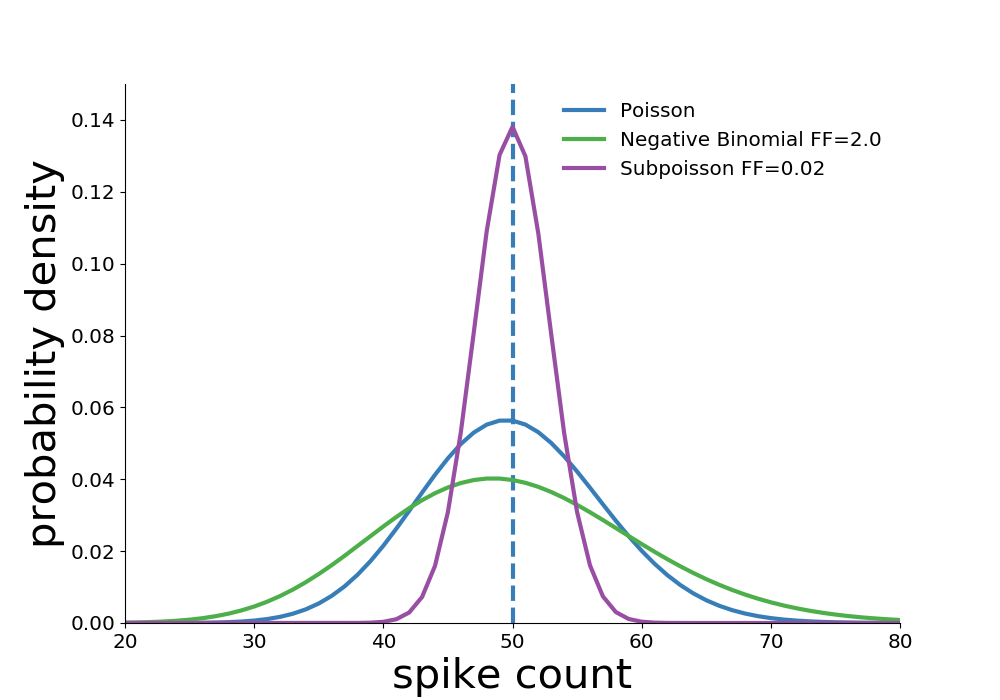

In [18]:
%matplotlib notebook

### plotting 3 poisson-type noise distribution at theta_0

import brewer2mpl
bmap = brewer2mpl.get_map('Set1', 'qualitative', 7)
colors = bmap.mpl_colors

ax = plt.subplot(111)
ax.axvline(x=50, color=colors[1], alpha=1, linestyle='--',linewidth=3)

f0=50/0.3

variability = "poisson"
ax.plot(p_n_theta(n_range,0),linewidth=3,color=colors[1],label="Poisson")
variability = "NB"
ax.plot(p_n_theta(n_range,0),linewidth=3,color=colors[2],label="Negative Binomial FF="+str(1 + f(0)*time_bin/R))
variability = "subpoisson"
ax.plot(p_n_theta(n_range,0),linewidth=3,color=colors[3],label="Subpoisson FF="+str('%.2f'%(sub_model.var(f(0)*time_bin)/f(0)*time_bin)))



ax.set_ylim(0,0.15)
ax.set_xlim(20,80)
ax.set_xlabel("spike count", fontsize=30)
ax.set_ylabel(r'probability density', fontsize=30)
ax.legend(frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

# Encoding transition in Poisson neuron

In [22]:
### High noise SSI ###

f0_low = 45/0.3
f0_high = 150/0.3

f0 = f0_low
shape,variability = "bell+baseline","poisson" # specs.
P_matrix_low_1 = compute_lookup_table()
spec_infs_low_1 = []
for i_n in  tqdm(range(len(n_range)),desc="computing specific information for each response") :
    spec_infs_low_1.append(spec_inf(P_matrix_low_1,i_n))
SSIs_low_1 = []
for theta in tqdm(range(len(theta_range)),desc="computing  SSI") :
    SSIs_low_1.append(SSI(P_matrix_low_1,spec_infs_low_1,theta))

sigmas_low = [np.sqrt(f(theta)) for theta in theta_range]

### Low noise SSI ###

f0 = f0_high
shape,variability = "bell+baseline","poisson" # specs.
P_matrix_high_1 = compute_lookup_table()
spec_infs_high_1 = []
for i_n in  tqdm(range(len(n_range)),desc="computing specific information for each response") :
    spec_infs_high_1.append(spec_inf(P_matrix_high_1,i_n))
SSIs_high_1 = []
for theta in tqdm(range(len(theta_range)),desc="computing  SSI") :
    SSIs_high_1.append(SSI(P_matrix_high_1,spec_infs_high_1,theta))

sigmas_high = [np.sqrt(f(theta)) for theta in theta_range]

<IPython.core.display.Javascript object>


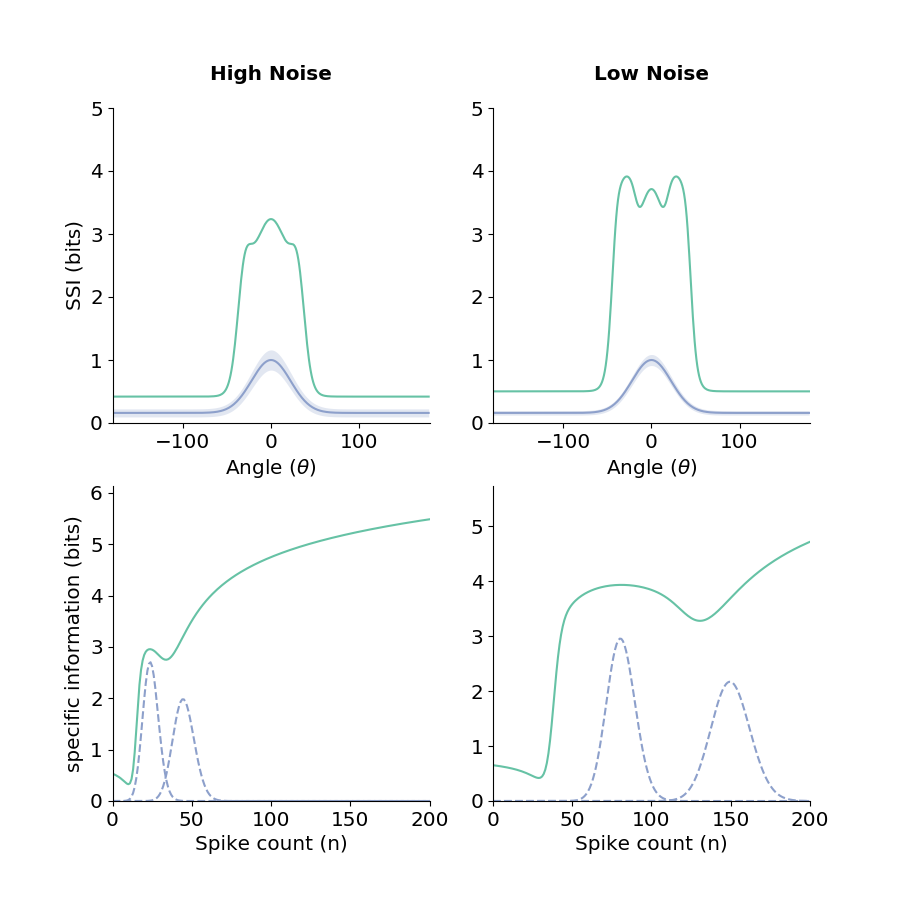

In [23]:
%matplotlib notebook

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


import brewer2mpl
fig, ax = plt.subplots(2, 2,figsize=(9,9))
plt.show()

bmap = brewer2mpl.get_map('Set2', 'qualitative', 3)
colors = bmap.mpl_colors
ax[1,0].plot(n_range,spec_infs_low_1,label = "Low noise", color=colors[0])
ax[1,1].plot(n_range,spec_infs_high_1,label ='High noise', color=colors[0])

ax[0,0].plot(theta_range,SSIs_low_1,label = "Low noise", color=colors[0])
ax[0,1].plot(theta_range,SSIs_high_1,label ='High noise', color=colors[0])

ax[0,0].plot(theta_range,[f(theta)/ f0 for theta in theta_range],color=colors[2])
ax[0,1].plot(theta_range,[f(theta)/ f0 for theta in theta_range],color=colors[2])

f0 = f0_low
ax[0,0].fill_between(theta_range,[(f(theta_range[i_theta])-1.96*sigmas_low[i_theta])/ f0 for i_theta in range(len(theta_range))],
                                 [(f(theta_range[i_theta])+1.96*sigmas_low[i_theta])/ f0 for i_theta in range(len(theta_range))], 
                                 alpha=0.25, linewidth=0, color=colors[2])
f0 = f0_high
ax[0,1].fill_between(theta_range,[(f(theta_range[i_theta])-1.96*sigmas_high[i_theta])/f0 for i_theta in range(len(theta_range))],
                                 [(f(theta_range[i_theta])+1.96*sigmas_high[i_theta])/f0 for i_theta in range(len(theta_range))], 
                                 alpha=0.25, linewidth=0, color=colors[2])


ax[1,0].plot(n_range,P_matrix_low_1[:,180]*12000, linestyle='--', color=colors[2])
ax[1,0].plot(n_range,P_matrix_low_1[:,152]*12000,  linestyle='--', color=colors[2])

ax[1,1].plot(n_range,P_matrix_high_1[:,180]*24000,  linestyle='--', color=colors[2])
ax[1,1].plot(n_range,P_matrix_high_1[:,152]*24000,  linestyle='--', color=colors[2])

ax[1,0].set_ylabel("specific information (bits)")

ax[0,0].set_ylabel("SSI (bits)")

ax[0,0].set_xlabel(r"Angle ($\theta$)")

ax[0,0].set_title(r"High Noise", fontweight='bold', pad=20)
ax[0,1].set_title(r"Low Noise", fontweight='bold', pad=20)

ax[1,1].set_xlabel("Spike count (n)")
ax[0,1].set_xlabel(r"Angle ($\theta$)")
ax[1,0].set_xlabel("Spike count (n)")

ax[1,0].set_ylim(bottom=0)
ax[1,1].set_ylim(bottom=0)
ax[0,0].set_ylim(bottom=0,top=5)
ax[0,1].set_ylim(bottom=0,top=5)

ax[0,0].set_xlim(left=-180,right=180)
ax[0,1].set_xlim(left=-180,right=180)

ax[1,0].set_xlim(left=0,right=200)
ax[1,1].set_xlim(left=0,right=200)

ax[1,0].spines['right'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)

plt.subplots_adjust()
plt.show()

# Finding the spike count at transition

In [21]:
shape,variability = "bell+baseline","poisson" # specs.

SSI_v = []
spec_inf_v = []

n_min = 5
n_max = 150
n_list = range(n_min,n_max,n_step)

tuning = []

for n in tqdm(n_list,desc="computing  SSI"):
    
    f0 = n/time_bin
    P_matrix = compute_lookup_table()
    spec_infs = []
    for i_n in  range(len(n_range)) :
        spec_infs.append(spec_inf(P_matrix,i_n))
    SSIs = []
    for theta in range(len(theta_range)):
        SSIs.append(SSI(P_matrix,spec_infs,theta))
    
    tuning.append([f(t)*0.3 for t in theta_range])
    spec_inf_v.append(spec_infs)
    SSI_v.append(SSIs)

C:\Users\fphub\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


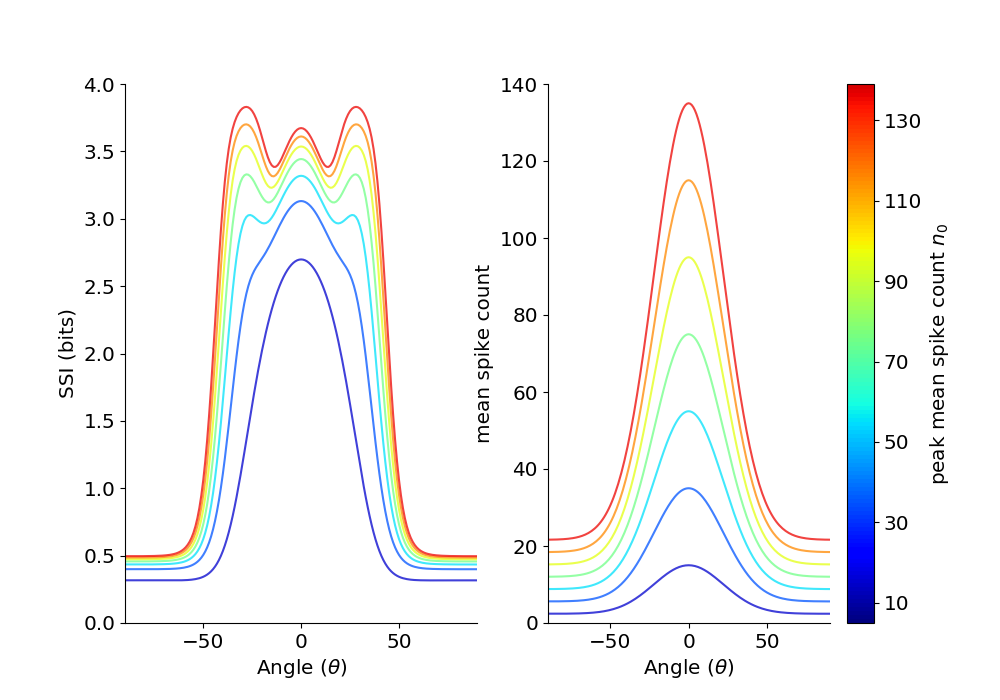

In [26]:
%matplotlib notebook
import matplotlib as mpl
fig, axs = plt.subplots(1,2)

colors = plt.cm.jet(np.linspace(0,1,len(SSI_v)))

for i in [10,30,50,70,90,110,130]:
    axs[0].plot(theta_range, SSI_v[i],color=colors[i],alpha=0.75,)

for i in [10,30,50,70,90,110,130]:
    axs[1].plot(theta_range, tuning[i],color=colors[i],alpha=0.75,)
plt.show()

axs[1].set_ylabel(r"mean spike count")
axs[0].set_ylabel("SSI (bits)")
axs[0].set_xlabel(r"Angle ($\theta$)")
axs[1].set_xlabel(r"Angle ($\theta$)")

axs[0].set_ylim(bottom=0,top=4)
axs[1].set_ylim(bottom=0,top=140)
axs[1].set_xlim(left=-90,right=90)
axs[0].set_xlim(left=-90,right=90)


cmap = plt.get_cmap('jet',len(SSI_v))
norm = mpl.colors.Normalize(vmin=n_min,vmax=n_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(10,130,7), 
             boundaries=np.arange(n_min,n_max-10,n_step),label="peak mean spike count $n_0$")
'''
axs[0].axvline(x=theta_range[152], color='b', alpha=0.25, linestyle='--')
axs[0].axvline(x=theta_range[208], color='b', alpha=0.25, linestyle='--')

axs[1].axvline(x=theta_range[152], color='b', alpha=0.25, linestyle='--')
axs[1].axvline(x=theta_range[208], color='b', alpha=0.25, linestyle='--')
'''

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

<IPython.core.display.Javascript object>


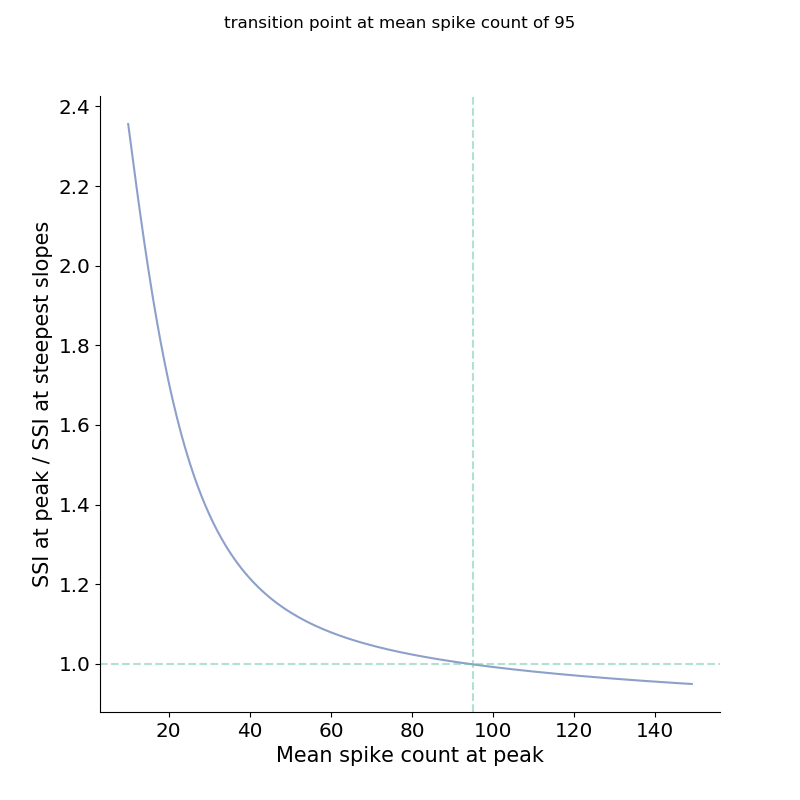

In [32]:
%matplotlib notebook
plt.rcParams["figure.figsize"] = (8,8)
bmap = brewer2mpl.get_map('Set2', 'qualitative', 3)
colors = bmap.mpl_colors

def plot_transition(ssi_list,n_list):
    
    # Here we plot the evolution of SSI_at_midwidth/SSI_at_center
    # after finding the thetha with the steepest SSI slope

    max_index = ssi_list[-1].index(max(ssi_list[-1]))
    ratios = [ssi_list[i][180]/ssi_list[i][max_index] for i in range(len(n_list))]
    i=0
    flag = False
    while(i < len(n_list) and not (flag)):
        if ratios[i] < 1 :
            flag = True
        else :
            i +=1

    plt.plot(n_list,ratios,color=colors[2])
    plt.ylabel(r"SSI at peak / SSI at steepest slopes",fontsize=15)
    plt.xlabel(r"Mean spike count at peak",fontsize=15)
    plt.axhline(y=1, color=colors[0], linestyle='--',alpha=0.5)
    plt.axvline(x=n_list[i], color=colors[0], linestyle='--',alpha=0.5)
    plt.suptitle("transition point at mean spike count of "+str(n_list[i]))
    plt.show()
    return(i)

ax = plt.subplot(111)
    
plot_transition(SSI_v,n_list)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# Transition for Negative Binomial Noise

In [34]:
shape,variability = "bell+baseline","NB" # specs.
f0 = 6000
SSI_v = []
spec_inf_v = []

n_min = 5
n_max = 150
n_list = range(n_min,n_max,n_step)

R = 150

for n in tqdm(n_list,desc="computing  SSI"):
    
    f0 = n/time_bin
    P_matrix = compute_lookup_table()
    spec_infs = []
    for i_n in  range(len(n_range)) :
        spec_infs.append(spec_inf(P_matrix,i_n))
    SSIs = []
    for theta in range(len(theta_range)):
        SSIs.append(SSI(P_matrix,spec_infs,theta))
    
    spec_inf_v.append(spec_infs)
    SSI_v.append(SSIs)

C:\Users\fphub\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


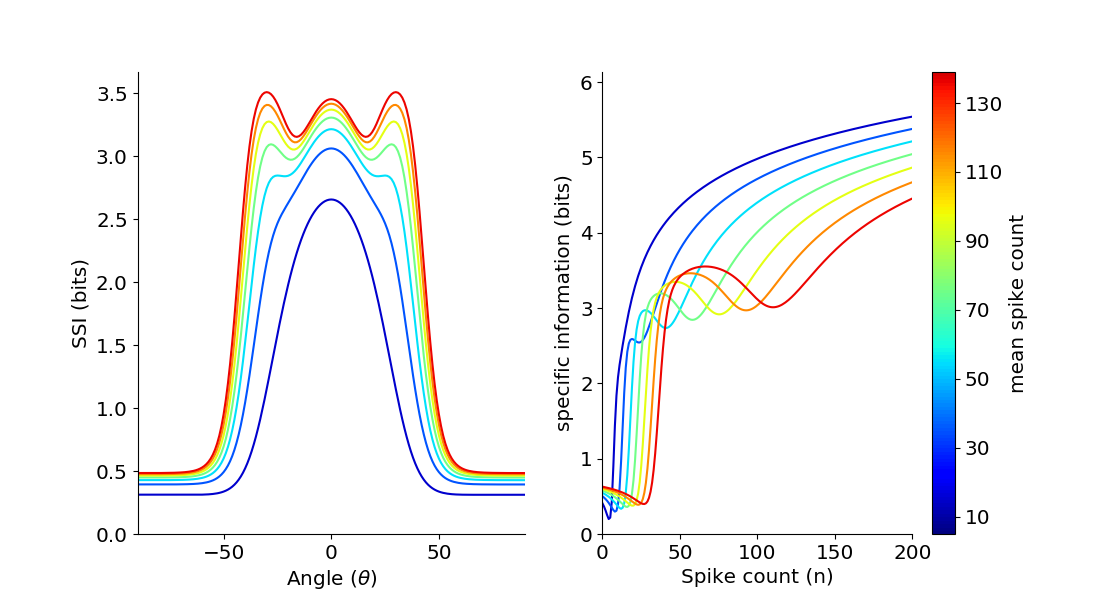

In [37]:
%matplotlib notebook
import matplotlib as mpl
fig, axs = plt.subplots(1,2,figsize=(11,6))

colors = plt.cm.jet(np.linspace(0,1,len(SSI_v)))

for i in [10,30,50,70,90,110,130]:
    axs[0].plot(theta_range, SSI_v[i],color=colors[i])
    
for i in [10,30,50,70,90,110,130]:
    axs[1].plot(n_range, spec_inf_v[i],color=colors[i])
plt.show()

shape,variability = "bell+baseline","poisson" # specs.
T=39*3
P_matrix = compute_lookup_table()
spec_infs = []
for i_n in  range(len(n_range)) :
    spec_infs.append(spec_inf(P_matrix,i_n))
SSIs = []
for theta in range(len(theta_range)):
    SSIs.append(SSI(P_matrix,spec_infs,theta))

axs[1].set_ylabel("specific information (bits)")
axs[0].set_ylabel("SSI (bits)")
axs[0].set_xlabel(r"Angle ($\theta$)")
axs[1].set_xlabel("Spike count (n)")

cmap = plt.get_cmap('jet',len(SSI_v))
norm = mpl.colors.Normalize(vmin=n_min,vmax=n_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(10,130,7), 
             boundaries=np.arange(n_min,n_max-10,n_step),label="mean spike count")

axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
axs[0].set_xlim(left=-90,right=90)
axs[1].set_xlim(left=0,right=200)

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

<IPython.core.display.Javascript object>


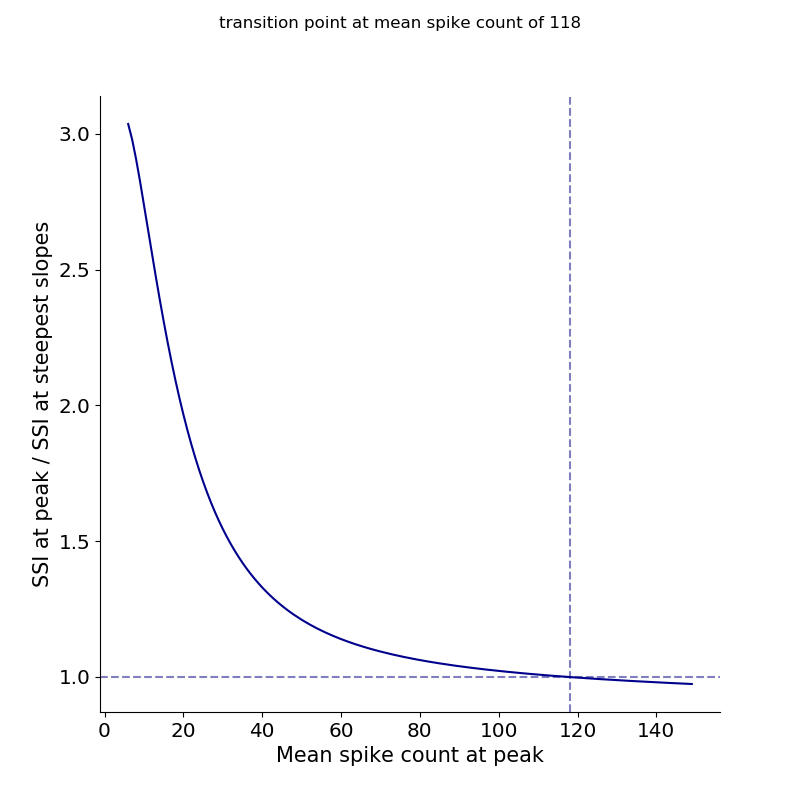

In [38]:
%matplotlib notebook

ax = plt.subplot(111)
    
plot_transition(SSI_v,n_list)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Transition for Subpoisson Noise

In [41]:
shape,variability = "bell+baseline","subpoisson" # specs.
%matplotlib notebook
SSI_v = []
spec_inf_v = []

n_range = np.arange(0,130,n_step) 
gamma, maxRange = -0.0005, n_range[-1]

print("creating subpoisson model")
sub_model = create_spiking_model(gamma, maxRange)
print("...done.")

n_min = 50
n_max = 130
n_list = range(n_min,n_max,n_step)


for n in tqdm(n_list,desc="computing  SSI"):
    
    f0 = n/time_bin
    #print("n:",n,"FF :",sub_model.var(f0*time_bin)/(f0*time_bin))

    P_matrix = compute_lookup_table()
    spec_infs = []
    for i_r in  range(len(n_range)) :
        spec_infs.append(spec_inf(P_matrix,i_r))
    SSIs = []
    for theta in range(len(theta_range)):
        SSIs.append(SSI(P_matrix,spec_infs,theta))
    
    spec_inf_v.append(spec_infs)
    SSI_v.append(SSIs)

creating subpoisson model
...done.


<IPython.core.display.Javascript object>


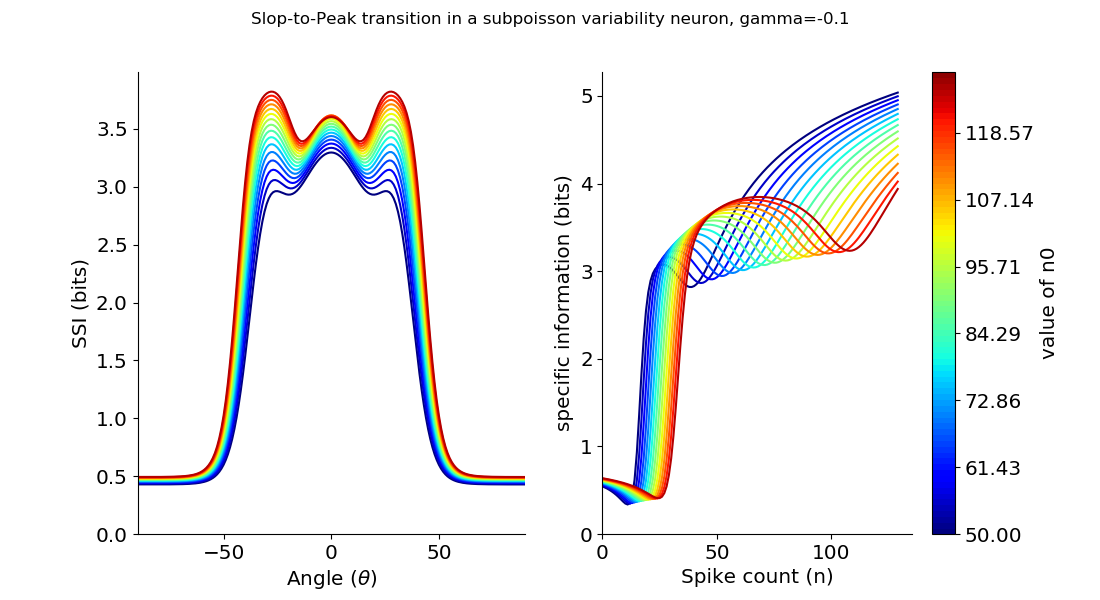

In [42]:
%matplotlib notebook
import matplotlib as mpl
fig, axs = plt.subplots(1,2,figsize=(11,6))

colors = plt.cm.jet(np.linspace(0,1,len(SSI_v)))

for i in range(0,len(SSI_v),5):
    axs[0].plot(theta_range, SSI_v[i],color=colors[i],alpha=1)

for i in range(0,len(spec_inf_v),5):
    axs[1].plot(n_range, spec_inf_v[i],color=colors[i],alpha=1)
plt.show()

axs[1].set_ylabel("specific information (bits)")
axs[0].set_ylabel("SSI (bits)")
axs[0].set_xlabel(r"Angle ($\theta$)")
axs[1].set_xlabel("Spike count (n)")
fig.suptitle('Slop-to-Peak transition in a subpoisson variability neuron, gamma=-0.1')

axs[0].set_ylim(bottom=0)
axs[1].set_ylim(bottom=0)
axs[0].set_xlim(left=-90,right=90)
axs[1].set_xlim(left=0)

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

cmap = plt.get_cmap('jet',len(SSI_v))
norm = mpl.colors.Normalize(vmin=n_min,vmax=n_max)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(n_min,n_max,8), 
             boundaries=np.arange(n_min,n_max,n_step),label="value of n0")


plt.savefig("subpoisson transition.png")

<IPython.core.display.Javascript object>


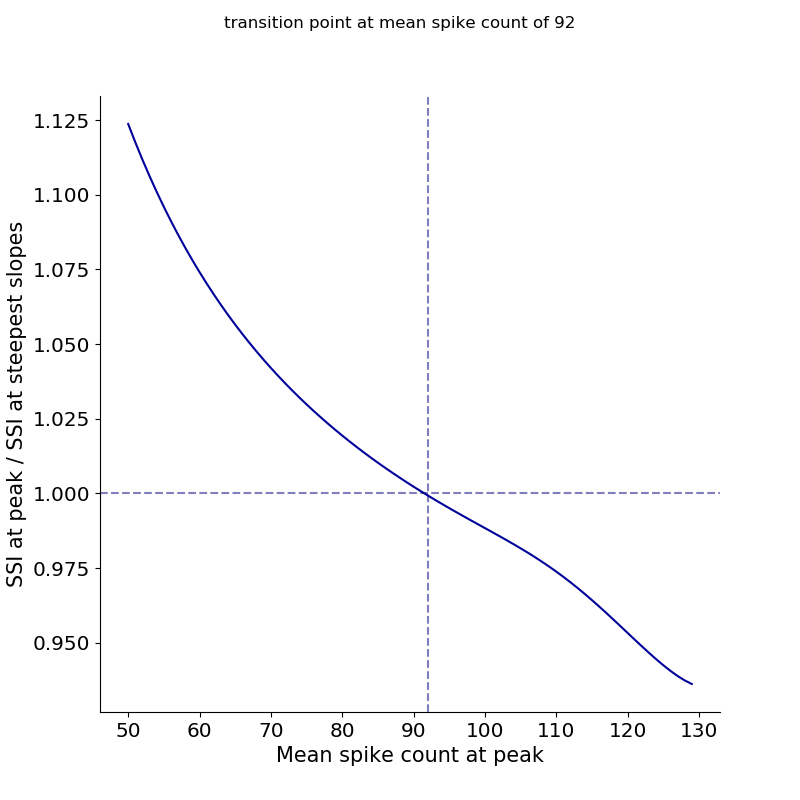

In [43]:
%matplotlib notebook

ax = plt.subplot(111)
    
plot_transition(SSI_v,n_list)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Transition spike count against the Fano Factor

In [73]:
### function to efficiently find the transition spike count ### 

def compute_ssi(current_n):
    global f0
    f0 = current_n/time_bin
    P_matrix1 = compute_lookup_table()
    spec_infs1 = []
    for i_n in  range(len(n_range)) :
        spec_infs1.append(spec_inf(P_matrix1,i_n))
    SSIs1 = []
    for theta in range(len(theta_range)):
        SSIs1.append(SSI(P_matrix1,spec_infs1,theta))
    return(SSIs1)
    
def find_transition_point(minn,maxn,max_slope):
    min_n=minn
    max_n=maxn
    
    # we make a dichotomy research of the transition mean spike count
    mid_n = np.floor((max_n+min_n)/2)
    ssi_list = compute_ssi(mid_n)
    max_index = max_slope
    #print(mid_n)
    #print(ssi_list[90]/ssi_list[max_index])
    while (np.abs((ssi_list[180]/ssi_list[max_index]) - 1) > 0.001 and min_n != max_n and min_n != max_n-1):
        if (ssi_list[180]/ssi_list[max_index] > 1) :
            min_n = mid_n
        else :
            max_n = mid_n
        mid_n = np.floor((min_n+max_n)/2)
        ssi_list = compute_ssi(mid_n)
        #print(mid_n)
        #print(ssi_list[90]/ssi_list[max_index])
    return(np.floor((min_n+max_n)/2))

In [74]:
# transition graph for NB FF > 1
shape,variability = "bell+baseline","NB" # specs.
n_range = np.arange(0,300,n_step)
NB_transition_point=[]
NB_FF = []

r_range = range(10,2000,100)
i = 0

for r in tqdm(range(10,2000,100)):
    R=r
    t = find_transition_point(10,300,150)
    print(t)
    FF = 1 + t/R
    NB_transition_point.append(t)
    NB_FF.append(FF)
    i += 1

299.0
129.0
110.0
105.0
102.0
102.0
100.0
100.0
100.0
99.0
99.0
99.0
98.0
98.0
98.0
98.0
98.0
98.0
98.0
98.0



In [82]:
# transitions for subpoisson FF < 1
shape,variability = "bell+baseline","subpoisson" 

gamma_range=np.arange(-0.5,-0.02,0.03)
sub_transition_point=[]
sub_FF = []
sub_var= []


var = []
for g in tqdm(gamma_range) :
    n_range = np.arange(0,50+g*20,n_step)
    maxRange = n_range[-1]
    gamma=g
    sub_model = create_spiking_model(gamma, maxRange)
    t = find_transition_point(1,maxRange,150)
    FF = sub_model.var(t)/t
    sub_transition_point.append(t)
    sub_FF.append(FF)
    sub_var.append(FF*t)

<IPython.core.display.Javascript object>


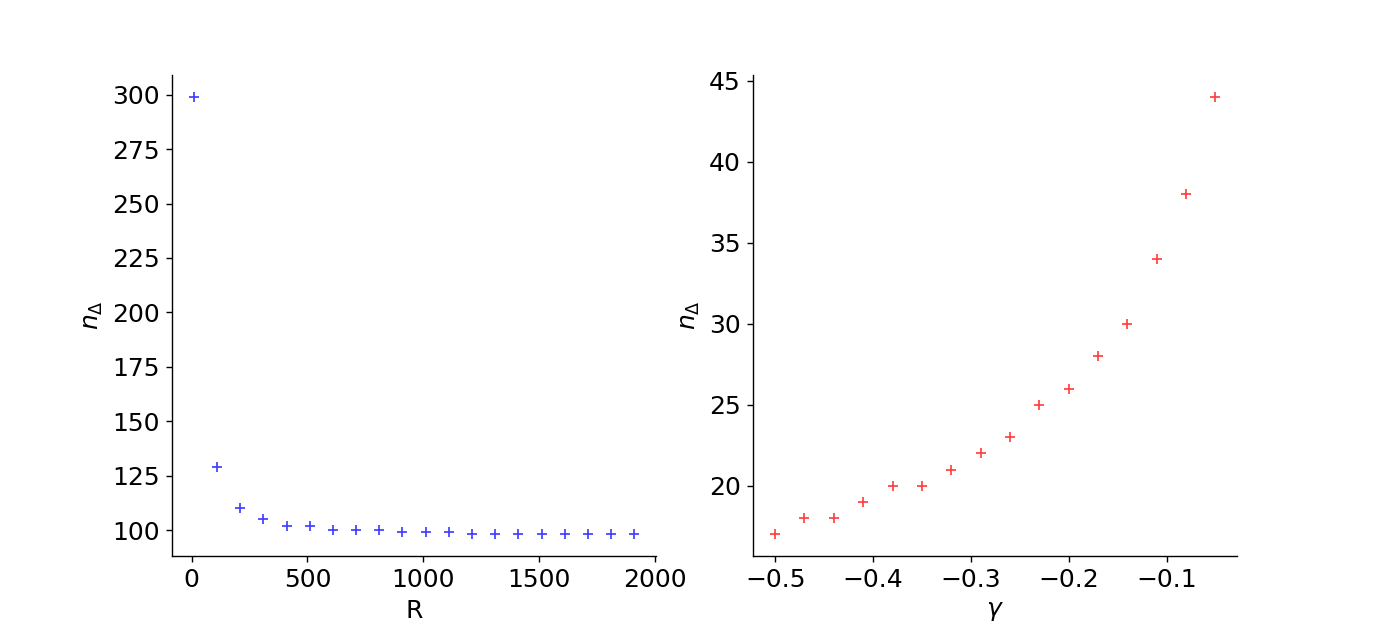

In [83]:
%matplotlib notebook

fig,axs = plt.subplots(1,2,figsize=(11,5))

axs[0].plot(r_range,NB_transition_point,'+',color='blue',label="Negative biomial noise",alpha=0.75) 
axs[1].plot(gamma_range,sub_transition_point,'+',color='red',label="sub-poisson noise",alpha=0.75)
axs[0].set_ylabel("$n_\Delta$")
axs[1].set_ylabel("$n_\Delta$")
axs[0].set_xlabel("R")
axs[1].set_xlabel("$\gamma$")

axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)


plt.show()

<IPython.core.display.Javascript object>


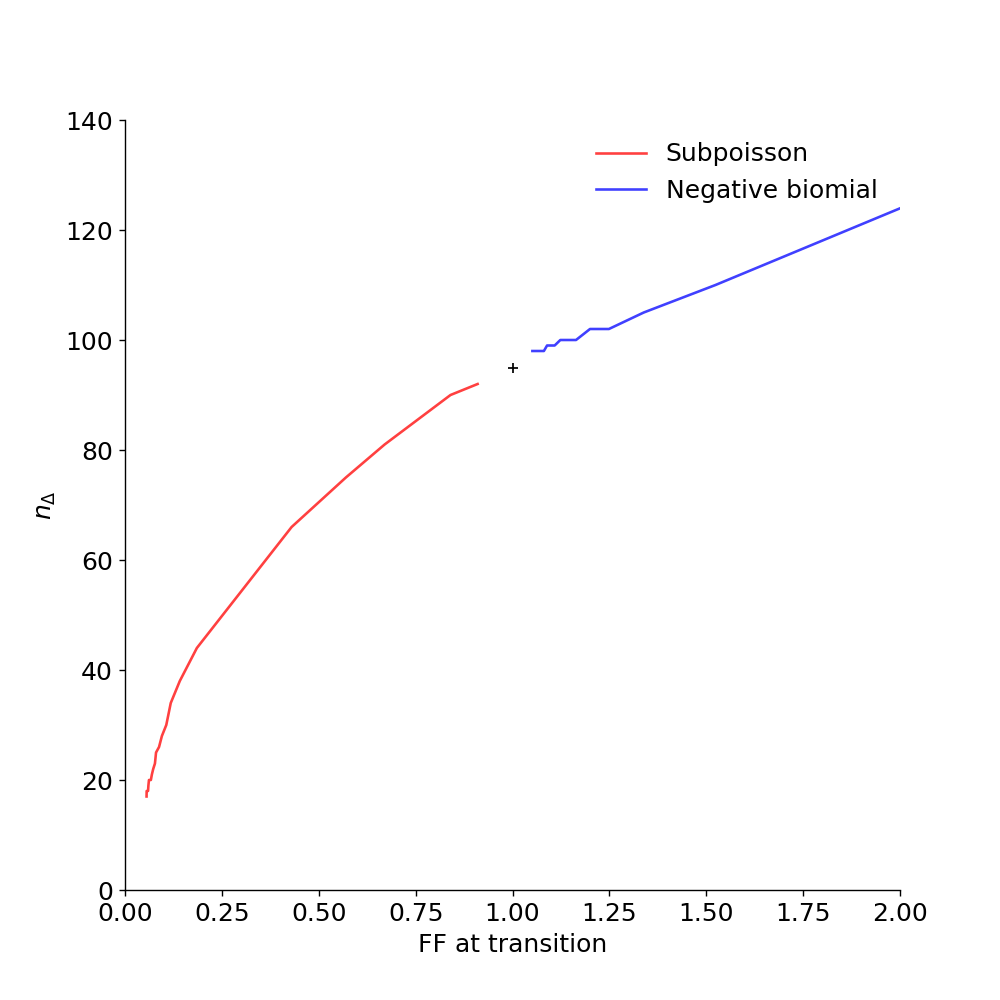

In [85]:
%matplotlib notebook


# point individually computed for some values of gamma
add_on_SP_FF = [0.43,0.57,0.67,0.84,0.91]
add_on_SP_transition_point = [66,75,81,90,92]

ax = plt.subplot(111)
plt.plot(sub_FF+add_on_SP_FF,sub_transition_point+add_on_SP_transition_point,color='red',label="Subpoisson",alpha=0.75)
plt.plot(NB_FF,NB_transition_point,color='blue',label="Negative biomial",alpha=0.75) 
plt.ylabel("$n_\Delta$")
plt.xlabel("FF at transition")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot([1],[95],'+',color='black')
plt.xlim(0,2)
plt.ylim(0,140)
plt.legend(frameon=False)

plt.show()